## Imports

In [1]:
# loading data
import pandas as pd
import string
#visualization
import matplotlib.pyplot as plt
import seaborn as sns

# numeric pro
import numpy as np


# Regular Expression for text cleaning
import re

# keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from wordcloud import WordCloud, STOPWORDS

#nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords



# Word2vec
import gensim
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import auc

## Data exploration & Analysis

In [2]:
df_train = pd.read_csv("train-balanced-sarcasm.csv")
df_test = pd.read_csv("test-balanced.csv")

In [3]:
df_train.head(4)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz


In [4]:
df_train.describe()

,label,score,ups,downs
count,1010826.0,1.010826e+06,1.010826e+06,1.010826e+06
mean,0.5,6.885676e+00,5.498885e+00,-1.458629e-01
std,0.5,4.834288e+01,4.127297e+01,3.529689e-01
min,0.0,-5.070000e+02,-5.070000e+02,-1.000000e+00
25%,0.0,1.000000e+00,0.000000e+00,0.000000e+00
50%,0.5,2.000000e+00,1.000000e+00,0.000000e+00
75%,1.0,4.000000e+00,3.000000e+00,0.000000e+00
max,1.0,9.070000e+03,5.163000e+03,0.000000e+00


In [5]:
df_train.columns

Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment'],
      dtype='object')

In [6]:
len(df_train)

1010826

In [7]:
df_train.isnull().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [8]:
df_train = df_train.drop(columns={'author','date','created_utc','subreddit','score','ups','downs','parent_comment'})

In [9]:
df_train

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.
...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...
1010822,1,"whatever you do, don't vote green!"
1010823,1,Perhaps this is an atheist conspiracy to make ...
1010824,1,The Slavs got their own country - it is called...


In [10]:
df_train['label'].value_counts()

0    505413
1    505413
Name: label, dtype: int64

#### Data Distribution

<AxesSubplot:xlabel='comment', ylabel='label'>

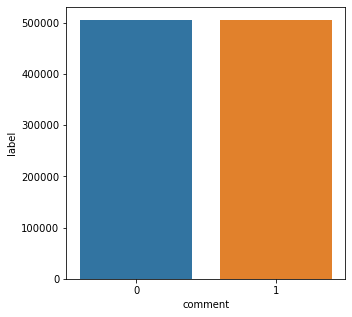

In [11]:
cum = df_train['label'].value_counts().to_frame()
cum['comment'] = cum.index
cumfig, ax = plt.subplots(figsize=(5,5))
sns.barplot(data=cum,x='comment',y='label',ax=ax)

#### Length of sarcastic and no sarcastic comments

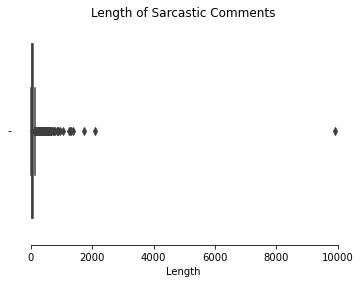

In [12]:
sns.boxplot(x= df_train.loc[df_train['label'] == 1, 'comment'].str.len()).set(title = 'Length of Sarcastic Comments', xlabel = 'Length')
sns.despine(offset=5, trim=True)
plt.show()

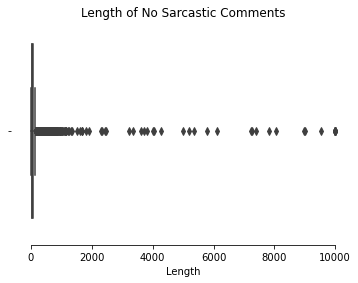

In [13]:
sns.boxplot(x= df_train.loc[df_train['label'] == 0, 'comment'].str.len()).set(title = 'Length of No Sarcastic Comments', xlabel = 'Length')
sns.despine(offset=5, trim=True)
plt.show()

#### word cloud

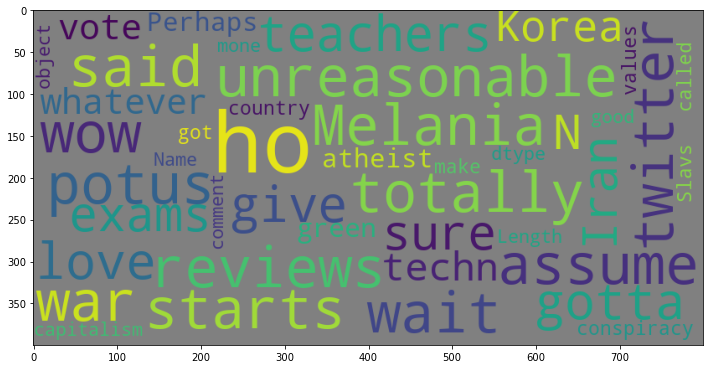

In [14]:
wordcloud = WordCloud(background_color='grey', stopwords = STOPWORDS,
                max_words = 500, max_font_size = 100, 
                random_state = 17, width=800, height=400)

plt.figure(figsize=(12, 12))
wordcloud.generate(str(df_train.loc[df_train['label'] == 1, 'comment']))
plt.grid(b= False)
plt.imshow(wordcloud);

## Data preprocessing

Machine learning models don't work with abreviations and contraction so we should replace them with contracted words with their non contracted version

In [15]:
contractions = pd.read_csv("contractions.csv")
contractions.head(4)

,Contraction,Meaning
0,'aight,alright
1,ain't,is not
2,amn't,am not
3,aren't,are not


In [16]:
# we have some emojis
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [17]:
word = "isn't"
ww = word in contractions.Contraction.values
contractions[contractions.Contraction==word].Meaning.values[0]

'is not'

In [18]:
def cleaning_text(s):
    s = str(s).lower().strip()
    s = " ".join([contractions[contractions.Contraction==word].Meaning.values[0] if word in contractions.Contraction.values else word for word in s.split()])
    #s = " ".join([emojis[word] if word in emojis.keys() else word for word in s.split()])

    # removing \n
    sss = '\n'
    s = re.sub(sss, '', s)
    # put spaces before & after punctuations to make words seprate
    s = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", s)
    # Remove >=2 continues spaces with 1 space.
    s = re.sub('[ ]{2,}', ' ', s).strip()
    return s

In [ ]:
df_train.comment = df_train.comment.apply(cleaning_text)
comments = df_train['comment'].values
labels = df_train['label'].values

In [ ]:
comments[3]

In [ ]:
comments

In [ ]:
df_train

In [49]:
# Term frequency (number of words),..
"""
cv=CountVectorizer() 
# this steps generates word counts for the words in your docs 
word_count_vector=cv.fit_transform(comments)


#compute idf
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 # sort ascending 
df_idf.sort_values(by=['idf_weights'])
# count matrix 
count_vector=cv.transform(comments) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False)"""


'\ncv=CountVectorizer() \n# this steps generates word counts for the words in your docs \nword_count_vector=cv.fit_transform(comments)\n\n\n#compute idf\ntfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) \ntfidf_transformer.fit(word_count_vector)\n\n# print idf values \ndf_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) \n # sort ascending \ndf_idf.sort_values(by=[\'idf_weights\'])\n# count matrix \ncount_vector=cv.transform(comments) \n \n# tf-idf scores \ntf_idf_vector=tfidf_transformer.transform(count_vector)\n\nfeature_names = cv.get_feature_names() \n \n#get tfidf vector for first document \nfirst_document_vector=tf_idf_vector[0] \n \n#print the scores \ndf = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) \ndf.sort_values(by=["tfidf"],ascending=False)'

## Vectorize

In [51]:
# settings that you use for count vectorizer will go here 
vectorizer = TfidfVectorizer() 
 
data_train= vectorizer.fit_transform(comments)

In [53]:
c_train,c_val,l_train,l_val = train_test_split(data_train,labels,test_size=0.15)